# Détection (Supervisée) de SPAM 

### Par LAURENT Jérémy

Ce document s'inscrit dans le périmètre du projet tutoré de l'un des groupes de la classe d'Année Spéciale de l'IUT Informatique LYON 1.
Réunissant :
- DUFOUR Alexandre
- FERRAND Gérome
- LAURENT Jeremy
- MOUSSU Nathan
- VATON Juliette

Ce groupe était placé sous le tutorat de M. VIDAL VINCENT.

Ce document représente les travaux de **Jérémy LAURENT**, au sujet d'un programme de **catégorisation de texte**.

A terme, le code inscrit dans ce document sera ré-employé dans un programme plus conséquent, réunissant les applications suivantes :
- Moteur de recherche (affecté à DUFOUR Alexandre)
- Détecteur de spams (affecté à LAURENT Jérémy)
- Analyseur d'opinion (affecté à VATON Juliette)
- Catégorisation de texte (affecté à FERRAND Gérome)

## Notre OBJECTIF :

Le but de cette application est d'associer automatiquement des labels prédéfinis à des textes.<br>
Tout au long de ce document, nous allons tenter de mettre en place un programme d'apprentissage automatique, composé de différent classifier. Dans un second temps, nous allons essayer de l'optimiser au maximum, tout en faisant attention de conserver un équilibre entre over- et under- fiting..

## A propos du DATASET :
Il s'agit d'un dataset très utilisé sur internet. Voici le lien:
https://www.kaggle.com/uciml/sms-spam-collection-dataset

## Plan du document :

1. **Chargement et observation de la composition du dataset**
1. ** Pré-traitage du procédé**


## 1.Chargement des bibliothèques et du Dataset

In [1]:
import sys
import nltk
import sklearn
import pandas
import numpy
import matplotlib.pyplot as plt
import pylab

#Importation de Scikit-learn
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Affichage des versions des bibliothèques
print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Numpy: {}'.format(numpy.__version__))

Python: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
NLTK: 3.3
Scikit-learn: 0.19.1
Pandas: 0.23.0
Numpy: 1.14.3


In [2]:
# Chargement des messages types SMS
df = pd.read_table('SMSSPamCollection', header=None, encoding='utf-8')
# Affichage des infos concernant le dataset
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
0    5572 non-null object
1    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB
None
      0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
# Conserve la première cologne de la matrice
# Compte les catégories (HAM/SPAM)
# Affiche le résultats
classes = df[0]
print(classes.value_counts())

ham     4825
spam     747
Name: 0, dtype: int64


## 2. Pré-traitage du procédé
### 2.1 Utilisation des expressions régulières

Il va falloir rassembler certaines données en un type de donnée (exemple les adresses mail auront toutes la même forme, idem pour les liens, les numéros etc...)  

In [4]:
from sklearn.preprocessing import LabelEncoder

# Convertir les labels de la classes en valeur binaire:
# 0 = ham and 1 = spam et les mettres dans une liste Y
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

print(Y[:10])
print("\n Nous avons transformé les 'ham' en '0' et les 'spam' en 1\n")
print(classes[:10])

[0 0 1 0 0 1 0 0 1 1]

 Nous avons transformé les 'ham' en '0' et les 'spam' en 1

0     ham
1     ham
2    spam
3     ham
4     ham
5    spam
6     ham
7     ham
8    spam
9    spam
Name: 0, dtype: object


In [5]:
# Stockage des SMS dans la variable text_messages
text_messages = df[1]
print(text_messages[:10])

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: 1, dtype: object


Suppression des adresses mail, URL, numéro de téléphone, nombres et tout ce qui s'apparente à du SPAM. Pour cela, on utilise des expressions régulières: elles sont disponibles sur le site: http://regexlib.com/Search.aspx?k=email

In [6]:
# Procédure qui remplace des adresses mails par 'emailaddress'
processed = text_messages.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Procédure qui remplace les URLs par 'webaddress'
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Procédure qui remplace les sympboles d'argents par 'moneysymb'
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Procédure qui remplace les numéros de téléhpone par 'phonenumbr' 
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumbr')
    
# Procédure qui remplace les chiffres/nombres par 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Suppression de la ponctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Remplacement des espaces multiples par des espaces simples
processed = processed.str.replace(r'\s+', ' ')

# Mise en minuscule des mots
processed = processed.str.lower()

In [7]:
# Affiche après Pré-traitement
print(processed)

0       go until jurong point crazy available only in ...
1                                ok lar joking wif u oni 
2       free entry in numbr a wkly comp to win fa cup ...
3            u dun say so early hor u c already then say 
4       nah i don t think he goes to usf he lives arou...
5       freemsg hey there darling it s been numbr week...
6       even my brother is not like to speak with me t...
7       as per your request melle melle oru minnaminun...
8       winner as a valued network customer you have b...
9       had your mobile numbr months or more u r entit...
10      i m gonna be home soon and i don t want to tal...
11      six chances to win cash from numbr to numbr nu...
12      urgent you have won a numbr week free membersh...
13      i ve been searching for the right words to tha...
14                     i have a date on sunday with will 
15      xxxmobilemovieclub to use your credit click th...
16                                oh k i m watching here 
17      eh u r

### 2.2 Procédure STOP-WORDS et STEMMING

In [8]:
# STOP-WORDS
# Suppression des mots-d'arrêts
stop_words = set(stopwords.words('english'))

processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

# STEMMING
ps = nltk.PorterStemmer()

processed = processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

In [9]:
# Affiche après Pré-traitement
print(processed)

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri numbr wkli comp win fa cup final tk...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
5       freemsg hey darl numbr week word back like fun...
6           even brother like speak treat like aid patent
7       per request mell mell oru minnaminungint nurun...
8       winner valu network custom select receivea mon...
9       mobil numbr month u r entitl updat latest colo...
10      gonna home soon want talk stuff anymor tonight...
11      six chanc win cash numbr numbr numbr pound txt...
12      urgent numbr week free membership moneysymbnum...
13      search right word thank breather promis wont t...
14                                            date sunday
15      xxxmobilemovieclub use credit click wap link n...
16                                             oh k watch
17      eh u r

## 3. Application du NOYAU VERSION SPAM
### 3.1 Génération du Bag-of-words

In [10]:
# Création du Bag-of-words
bag = []

# On met les mots dans le Bag
for message in processed:
    words = word_tokenize(message)
    for w in words:
        bag.append(w)

bag = nltk.FreqDist(bag)

In [11]:
# Affichage des mots les plus communs (top 15)
print('Le nombre de mot: {}'.format(len(bag)))
print('Les mots les plus communs sont: {}'.format(bag.most_common(15)))
pd.DataFrame([bag.most_common(20)])

Le nombre de mot: 6579
Les mots les plus communs sont: [('numbr', 2648), ('u', 1207), ('call', 674), ('go', 456), ('get', 451), ('ur', 391), ('gt', 318), ('lt', 316), ('come', 304), ('moneysymbnumbr', 303), ('ok', 293), ('free', 284), ('day', 276), ('know', 275), ('love', 266)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(numbr, 2648)","(u, 1207)","(call, 674)","(go, 456)","(get, 451)","(ur, 391)","(gt, 318)","(lt, 316)","(come, 304)","(moneysymbnumbr, 303)","(ok, 293)","(free, 284)","(day, 276)","(know, 275)","(love, 266)","(like, 261)","(got, 252)","(time, 252)","(good, 248)","(want, 247)"


In [12]:
# Utilisation des 1500 mots les plus communs comme références
word_features = list(bag.keys())[:1500]

Nous avons donc une liste des 1500 mots les plus présents dans tout le dataset d'origine. On créer une fonction qui retourne les mots qui sont à la fois dans cette liste et dans les SMS traités

In [13]:
# Fonction qui retourne les mots présent dans la chaine de caractère et dans word_features
def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

La fonction Find_feature va alors prendre chaque sms (de façon quasi-aléatoire) et associer les mots retournée aux labels qui sont associés aux sms. Cela va donc permettre de reconnaitre les mots qui se trouvent dans des textes déjà classifiés comme des SPAMs 

In [14]:
# Automatision de la fonction find_feature
messages = list(zip(processed, Y))
# Echantillonnage des données
seed=1
np.random.seed = seed
np.random.shuffle(messages)
featuresets = [(find_features(text), label) for (text, label) in messages]

In [15]:
# Mise en place:
# - training set = utilisé par l'algorithme pour s'entrainer
# - testing set = permet de mesurer l'erreur du model final sur des données qu'il n'a jamais vu
from sklearn import model_selection

# Répartition: 75% pour le training set et 25 % pour le testing set
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=seed)
print(len(training))
print(len(testing))

#Training pour les méta_modèles (cf partie 4.2)
training_n2=training
training_n3=training

4179
1393


In [16]:
pd.DataFrame([testing])

,0,1,2,3,4,5,6,7,8,9,...,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392
0,"({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...",...,"({'go': True, 'jurong': False, 'point': False,...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': True, 'jurong': False, 'point': False,...","({'go': True, 'jurong': False, 'point': False,...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False...","({'go': False, 'jurong': False, 'point': False..."


On a deux matrices contenant chacune des sous listes de mots de chaque SMS avec le label

## 4. Apprentissage supervisé
### 4.1 Classification avec Scikit-Learn

Maintenant que nous avons notre jeu de données traité, nous allons utiliser un classifieur de Sklearn. Il faut néanmoins choisir le classifieur adéquat pour obtenir le meilleur résultat possible. Ainsi dans cette partie nous testerons différents classifieur un à un.

Comme le choix des hyperparamètres est compliqué (demande des connaissances poussées en mathématiques ainsi qu'une compréhension avancée du model que je n'ai pas encore), nous conservevons la plupart hyperparamères par défaut. Nous utilisons également l'incateur "accuracy" pour évaluer la performance globale du modèle. Sa formule est:

$$(TP+TN)/(TP+TN+FP+FN)$$
 
- TP = Vrai positif 
- TN = Vrai négatif 
- FP = Faux posifif 
- FN = Faux négatif

cf: https://stanford.edu/~shervine/l/fr/teaching/cs-229/pense-bete-machine-learning-petites-astuces

#### 4.1.A Test du classifieur SVC (Support Vector Classification)
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [17]:
# Paramétrage du classifier 
# (kernel = poly/rbf/sigmoid/linear/precomputed/callable)
model = SklearnClassifier(SVC(kernel = 'linear'))

# On entraine le model
model.train(training)

# On test le classifier en utilisant l'échantillon "testing"
accuracy = nltk.classify.accuracy(model, testing)*100
accuracy = (round(accuracy,2))
print ("La précision de classification est de "+str(accuracy)+"%")

La précision de classification est de 98.42%


Essayons à présent de faire varier les hyperparamètres afin d'optimiser le classifieur SVC

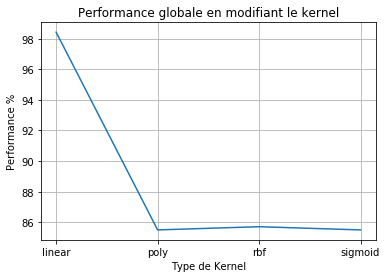

In [18]:
# Les paramètres
K=['linear','poly','rbf','sigmoid']

# Les résultats
AccuracyTAB=[]

# Test du classifieur en modifiant les Kernels
for i in range(len(K)):
    model = SklearnClassifier(SVC(kernel = K[i]))
    model.train(training)
    accuracy = nltk.classify.accuracy(model, testing)*100
    AccuracyTAB.append(round(accuracy,2))
    
# Affichage des courbes
plt.grid(True)
plt.plot(K,AccuracyTAB)
plt.title("Performance globale en modifiant le kernel")
plt.xlabel("Type de Kernel")
plt.ylabel("Performance %")
plt.show()

Le graphe permet de mettre en évidence le choix du meilleur hyperparamètre "kernel" pour l'algorithme de classification SVC dans ce cas d'utilisation. Il existe d'autres hyperparamètres mais nous n'allons les modifiers pour plusieurs raisons:

- Le nombre de combinaisons est énorme, il faudrait beaucoup de temps pour tout tester
- Nous avons déjà un bon résultats (98% de réussite en moyenne)

Essayons de faire de même avec plusieurs avec d'autres algorithmes de classification

#### 4.1.B Test du classifieur DecisionTreeClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [19]:
model = SklearnClassifier(DecisionTreeClassifier())
# On entraine le model
model.train(training)

# On test le classifier en utilisant l'échantillon "testing"
accuracy = nltk.classify.accuracy(model, testing)*100
accuracy = (round(accuracy,2))
print ("La précision de classification est de "+str(accuracy)+"%")

La précision de classification est de 97.49%


Dans ce cas, nous laissons les hyperparamètres par défaut et nous pouvons constater que ce classifieur est un peu moins performant que le précédent

#### 4.1.C Test du classifieur KNN (KNeighborsClassifier)
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

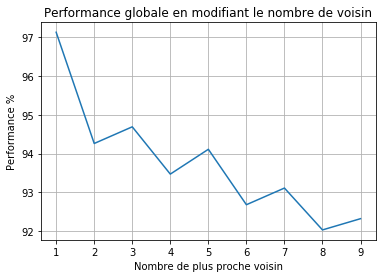

In [20]:
# Les paramètres
N=[1,2,3,4,5,6,7,8,9]

# Les résultats
AccuracyTAB=[]

# Test du classifieur en modifiant le nombre de voisin
for i in range(len(N)):
    model = SklearnClassifier(KNeighborsClassifier(n_neighbors= N[i]))
    model.train(training)
    accuracy = nltk.classify.accuracy(model, testing)*100
    AccuracyTAB.append(round(accuracy,2))
    
# Affichage des courbes
plt.grid(True)
plt.plot(N,AccuracyTAB)
plt.title("Performance globale en modifiant le nombre de voisin")
plt.xlabel("Nombre de plus proche voisin")
plt.ylabel("Performance %")
plt.show()

Dans le cas de la variation du nombre de plus proche voisin pour l'algorithme de classification du KNN, nous pouvons voir qu'il est plus performant de choisir un nombre de voisin égal à 1.

#### 4.1.D Test du classifieur RandomForestClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

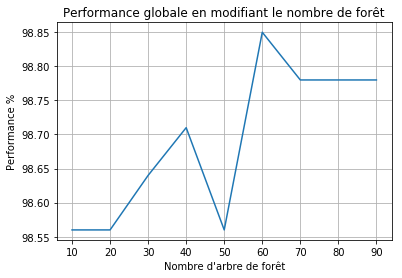

In [21]:
# Les paramètres
E=np.arange(10, 100, 10)

# Les résultats
AccuracyTAB=[]

# Test du classifieur en modifiant le nombre de forêt
for i in range(len(E)):
    model = SklearnClassifier(RandomForestClassifier(n_estimators=E[i]))
    model.train(training)
    accuracy = nltk.classify.accuracy(model, testing)*100
    AccuracyTAB.append(round(accuracy,2))
    
# Affichage des courbes
plt.grid(True)
plt.plot(E,AccuracyTAB)
plt.title("Performance globale en modifiant le nombre de forêt")
plt.xlabel("Nombre d'arbre de forêt")
plt.ylabel("Performance %")
plt.show()

Dans le cas de la variation du nombre d'arbre de forêt pour l'algorithme de classification RandomForest, nous pouvons voir qu'il est plus performant de choisir un nombre d'arbre élevé (ce nombre étant limité à 100).

A noter que ce graphe n'est pas reproductible, en effet la courbe varie énormément entre 10 et 80, mais l'intervalle de performance est toujours située entre 98.5% et 100%. En général le maximum est atteint avec un nombre de forêt égal à 100.

#### 4.1.E Test du classifieur LogistiqueRegression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

T:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


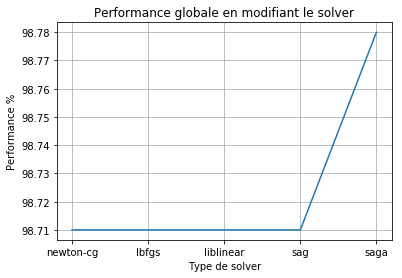

In [22]:
# Les paramètres
M=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Les résultats
AccuracyTAB=[]

# Test du classifieur en modifiant le solver
for i in range(len(M)):
    model = SklearnClassifier(LogisticRegression(solver=M[i]))
    model.train(training)
    accuracy = nltk.classify.accuracy(model, testing)*100
    AccuracyTAB.append(round(accuracy,2))
    
# Affichage des courbes
plt.grid(True)
plt.plot(M,AccuracyTAB)
plt.title("Performance globale en modifiant le solver")
plt.xlabel("Type de solver")
plt.ylabel("Performance %")
plt.show()

Dans ce cas la, la modification du solver n'a quasiment aucun impact sur la performance de l'algorithme (entre 98 et 99%).

#### 4.1.F Test du classifieur Naive_bayes.MultinomialNB
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

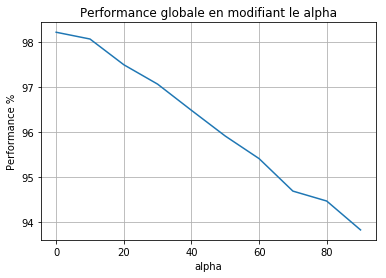

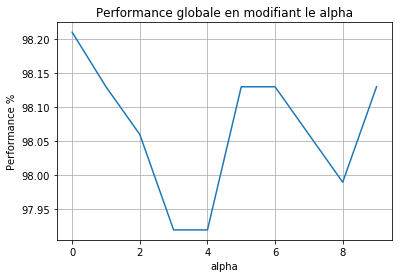

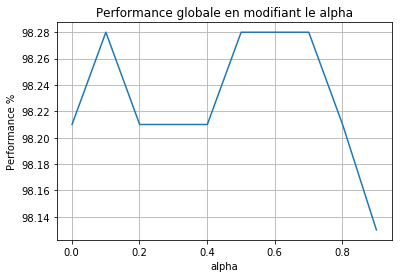

In [23]:
# Les paramètres
A=np.arange(0.001, 100, 10)
B=np.arange(0.001, 10, 1)
C=np.arange(0.001, 1, 0.1)

# Les résultats
AccuracyTAB=[]
AccuracyTAB2=[]
AccuracyTAB3=[]

# Test du classifieur en modifiant le alpha
for i in range(len(A)):
    model = SklearnClassifier(MultinomialNB(alpha=A[i]))
    model.train(training)
    accuracy = nltk.classify.accuracy(model, testing)*100
    AccuracyTAB.append(round(accuracy,2))
    
for i in range(len(B)):
    model = SklearnClassifier(MultinomialNB(alpha=B[i]))
    model.train(training)
    accuracy = nltk.classify.accuracy(model, testing)*100
    AccuracyTAB2.append(round(accuracy,2))
    
for i in range(len(C)):
    model = SklearnClassifier(MultinomialNB(alpha=C[i]))
    model.train(training)
    accuracy = nltk.classify.accuracy(model, testing)*100
    AccuracyTAB3.append(round(accuracy,2))
    
# Affichage des courbes
plt.grid(True)
plt.plot(A,AccuracyTAB)
plt.title("Performance globale en modifiant le alpha")
plt.xlabel("alpha")
plt.ylabel("Performance %")
plt.show()

plt.grid(True)
plt.plot(B,AccuracyTAB2)
plt.title("Performance globale en modifiant le alpha")
plt.xlabel("alpha")
plt.ylabel("Performance %")
plt.show()

plt.grid(True)
plt.plot(C,AccuracyTAB3)
plt.title("Performance globale en modifiant le alpha")
plt.xlabel("alpha")
plt.ylabel("Performance %")
plt.show()

Les trois courbes permettent de mettre en évidence que l'hyperparamètre "alpha" doit être faible.

### 4.2 Génération d'un Meta-Classifieur avec Scikit-Learn 

On adopte le principe des méthodes ensemblistes: c'est à dire utiliser des classifieurs différents (qui ne classent pas de la même manière) pour obtenir de meilleurs résultats. Nous avons déterminé dans la précédente partie des hyperparamètres qui améliore la performance global de chaque algorithme de classfication. Nous allons réaliser deux méta_classifieurs dont le premier aura tous les hyperparamètres par défaut et l'autres aura les hyperparamètres déterminés dans la partie d'avant.

#### 4.2.A Meta_modèle normal

In [24]:
# Modèle individuels
KNC=KNeighborsClassifier()
DTC=DecisionTreeClassifier()
RFC=RandomForestClassifier()
LG=LogisticRegression()
SGDC=SGDClassifier()
M=MultinomialNB()
SC=SVC()

# Construction du meta-modèle
meta_model = SklearnClassifier(VotingClassifier(estimators=[('k1',KNC),('k2',DTC),('k3',RFC),('k4',LG),('k5',SGDC),('k6',M),('k7',SC)],voting="hard"))
meta_model.train(training_n3)
accuracy = nltk.classify.accuracy(meta_model, testing)*100
accuracy = (round(accuracy,3))
print("Précision de meta_classifieur: {}".format(accuracy)+"%")

T:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Précision de meta_classifieur: 98.492%


T:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### 4.2.3 Meta_Modèle Optimisé

In [25]:
# Modèle individuels optimisés
KNC=KNeighborsClassifier(n_neighbors=1)
DTC=DecisionTreeClassifier()
RFC=RandomForestClassifier(n_estimators=100)
LG=LogisticRegression(solver='saga')
SGDC=SGDClassifier(max_iter = 100)
M=MultinomialNB(alpha=0.4)
SC=SVC(kernel = 'linear')

# Construction du meta-modèle
meta_model2 = SklearnClassifier(VotingClassifier(estimators=[('k1',KNC),('k2',DTC),('k3',RFC),('k4',LG),('k5',SGDC),('k6',M),('k7',SC)],voting="hard"))
meta_model2.train(training_n2)
accuracy2 = nltk.classify.accuracy(meta_model2, testing)*100
accuracy2 = (round(accuracy2,3))
print("Précision de meta_classifieur optimisé: {}".format(accuracy2)+"%")

T:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Précision de meta_classifieur optimisé: 98.78%


T:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


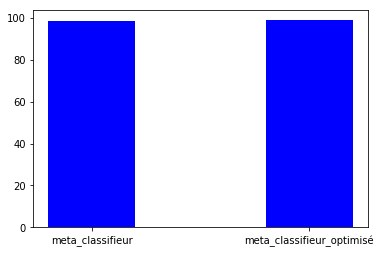

In [26]:
#Diagramme de comparaison
fig = plt.figure()

x = ['meta_classifieur','meta_classifieur_optimisé']
height = [accuracy,accuracy2]
width = 0.4 # modifier la largeur des bâtons
plt.bar(x, height, width, color='b' )
plt.show()

## 5.Test de l'algorithme d'apprentissage

### 5.1 Prédiction du dataset testing

Nous allons à présent tester l'algorithme sur le jeu de données testing (différents de la partie d'apprentissage)

In [27]:
#On dézipe testing pour séparer les labels et les features
txt_features, labels = zip(*testing)

prediction = meta_model2.classify_many(txt_features)

T:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 5.1 Explication des résultats

#### 5.1.1 Matrice de confusion

In [28]:
#Explication du tableau de résultats
print("precision = À quel point les prédictions positives sont précises")
print("TP/(TP+FP)\n")

print("recall = Couverture des observations vraiment positives")
print("TP/(TP+FN)\n")

print("F1_score = Indicateur hybride utilisé pour les classes non-balancées")
print("2TP/(2TP+FP+FN)\n")

# affichage des résultats
erreur= round((100-accuracy),3)
print("L'erreur est de: {}".format(erreur)+" %\n")
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['En réalité', 'En réalité'], ['NON-SPAM', 'SPAM']],
    columns = [['Ce qui été prédit', 'Ce qui été prédit'], ['NON-SPAM', 'SPAM']])

precision = À quel point les prédictions positives sont précises
TP/(TP+FP)

recall = Couverture des observations vraiment positives
TP/(TP+FN)

F1_score = Indicateur hybride utilisé pour les classes non-balancées
2TP/(2TP+FP+FN)

L'erreur est de: 1.508 %

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1191
          1       0.99      0.92      0.96       202

avg / total       0.99      0.99      0.99      1393



Ce qui été prédit     
                             NON-SPAM SPAM
En réalité NON-SPAM              1190    1
           SPAM                    16  186

#### 5.1.2 Courbe ROC

La courbe ROC représente le taux de True Positives en fonction de taux de False Positives et obtenue en faisant varier le seuil. 

cf: https://stanford.edu/~shervine/l/fr/teaching/cs-229/pense-bete-machine-learning-petites-astuces

tuto traçage de la courbe: https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/

Ces indicateurs sont résumés dans le tableau suivant :

|        Indicatieur          |       Formule         |       Equivalent      |
|-----------------------------|-----------------------|-----------------------|
|   True Positive Rate TPR    |    $(TP)/(TP+FN)$     |   Recall, sensitivity |
|   False Positive Rate FPR   |    $(FP)/(TN+FP)$     |      1-specificity    |


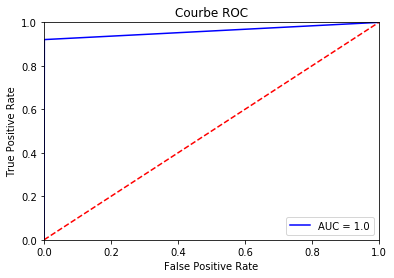

In [30]:
# Importation bibliothèques
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

# Transformation de la liste en tableau
labelsTAB = np.asarray(labels)

# Calcul du FPR et du TPR
false_positive_rate, true_positive_rate, thresholds = roc_curve(labelsTAB, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Affichage de la courbe
plt.title('Courbe ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.1f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 6. Conclusion

Nous avons réalisé un algorithme de classification de SPAM à partie d'un jeu de données (SPAM email). Sur la phase de test (avec le même jeu de données), l'erreur de l'algorithme est de 1%. 